In [1]:
import numpy as np
import random
import tensorflow as tf
from copy import copy, deepcopy

In [2]:
class Board():
    
    def __init__(self, deck):
        
        self.deck = random.sample(deck, 5) # each game only 5 cards are selected from the deck
        self.color = 0 
        self.player1_cards = self.deck[:2]
        self.player2_cards = self.deck[2:4]
        self.remaining_card = self.deck[4]
        self.board_size = 5 # 5x5 board    
        self.board_2D = np.array([[ 1,  1,  2,  1,  1],
                                  [ 0,  0,  0,  0,  0],
                                  [ 0,  0,  0,  0,  0],
                                  [ 0,  0,  0,  0,  0],
                                  [-1, -1, -2, -1, -1]])
        self.board_state = self.get_board_state()
        self.layer_code = self.get_layer_codes()
        self.layer_decode = {k :v for v,k in self.layer_code.items()}
        self.result = {0 : 0,
                       1 : 0,
                      -1 : 0}
        
    def get_layer_codes(self):
        """return the 'codes' of each plane of the NN"""
        
        layer_code = {}
        i = 0
        for card in deck:
            for move in card.moves:
                if move not in layer_code :
                    layer_code[move] = i
                    i += 1
        return layer_code
            
    def get_board_state(self):
        """ Return the board state, a 5 x 5 x 5 
        the first 5x5 represent the board, while the first 4 planes represent the piece and the last one the player."""
        
        board_state = np.zeros((5, 5, 5))
            
        for k, piece in enumerate([1, 2, -1, -2]):
            for i in range(self.board_size):
                for j in range(self.board_size):
                    if self.board_2D[i][j] == piece:
                        board_state[k][i][j] = 1
                        
        if self.color == 0:
            board_state[4] = np.zeros((5, 5))
        else:
            board_state[4] = np.ones((5, 5))
        
        return board_state
        
        
    def get_legal_moves(self, policy):
        """Returns all the legal moves for a policy obtained with the neural network """
        
        # transform to positive output
        policy = policy - np.min(policy) + 1e-9 #to avoid div by 0 if all element are equals and negatifs
        
        possible_policy = np.zeros((5, 5, 13))
        if self.color == 0:
            player_board2D = self.board_state[0] + self.board_state[1]
            player_cards = self.player1_cards
        else:
            player_board2D = self.board_state[2] + self.board_state[3]
            player_cards = self.player2_cards
       
        # keep only the possible moves, considering the 2 card the player have.
        possibles_moves = set()
        for card in player_cards:
            for move in card.moves:
                possibles_moves.add(move)
            
        for move in possibles_moves:
            for i in range(5):
                for j in range(5):
                    if player_board2D[i][j] != 0 :
                        if (0 <= i - move[1] < 5) and (0 <= j + move[0] < 5):
                            possible_policy[i - move[1]][j + move[0], self.layer_code[move]] = policy[i - move[1]][j + move[0], self.layer_code[move]]
                            
        # The illegal moves are the one where there is already an ally piece on the board
        # we can perform element wise multiplication for each plane to get the legal moves
        for k in range(possible_policy.shape[2]):
            possible_policy[:, :, k] = tf.multiply(possible_policy[:, :, k], (1 - player_board2D))
            
        # Then we normalize to [0, 1]
        possible_policy = possible_policy / np.sum(possible_policy)
        return possible_policy

    
#     def best_move(self, policy):
#         """ Return the line, column and depth of the best_move from the policy """
#         layer_of_move = np.argmax(policy)%13
#         column_of_move, line_of_move  = np.argmax(policy[:, :, layer_of_move])%5, np.argmax(policy[:, :, layer_of_move])//5
#         return line_of_move, column_of_move, layer_of_move
   

    def move(self, policy): # COPY EVERYTHING TO CREATE AN NEW STATE 
        """Return the next state of the game, choosing a random move from the policy"""
       
        legals_moves = self.get_legal_moves(policy)
        legals_moves_flat = legals_moves.flatten() 
        
        # pick a move according to their probability
        rd_number = np.random.rand()
        move_choosed = next(x[0] for x in enumerate(np.cumsum(legals_moves_flat)) if x[1] > rd_number)

        plane = move_choosed % 13
        column = move_choosed // 13 % 5
        line = move_choosed // 13 // 5

        piece_to_move = (line + self.layer_decode[plane][1], column - self.layer_decode[plane][0])
        
        # create the next state
        cls = self.__class__
        next_state = cls.__new__(cls)
        next_state.board_size = self.board_size
        next_state.layer_code = self.layer_code
        next_state.layer_decode = self.layer_decode
        
        # move the piece
        next_state.board_2D = self.board_2D.copy()
        next_state.board_2D[line, column] = self.board_2D[piece_to_move]
        next_state.board_2D[piece_to_move] = 0 
        
        # How to know which card the policy choose to move when both can play the move ??
        if self.color == 0:
            if (line, column) in self.player1_cards[0].moves:
                print(f"player {self.color} plays {self.player1_cards[0].name}")
                next_state.player1_cards = [self.player1_cards[1], self.remaining_card]
                next_state.remaining_card = self.player1_cards[0]
            else:
                print(f"player {self.color} plays {self.player1_cards[1].name}")
                next_state.player1_cards = [self.player1_cards[0], self.remaining_card]
                next_state.remaining_card = self.player1_cards[1]
            
            next_state.color = 1
            next_state.player2_cards = self.player2_cards
            next_state.board_state = next_state.get_board_state()
            
        else:
            if (line, column) in self.player2_cards[0].moves:
                print(f"player {self.color} plays {self.player2_cards[0].name}")
                next_state.player2_cards = [self.player2_cards[1], self.remaining_card]
                next_state.remaining_card = self.player2_cards[0]
            else:
                print(f"player {self.color} plays {self.player2_cards[1].name}")
                next_state.player2_cards = [self.player2_cards[0], self.remaining_card]
                next_state.remaining_card = self.player2_cards[1]
                
            next_state.color = 0
            next_state.player1_cards = self.player1_cards
            next_state.board_state = next_state.get_board_state()

        return next_state

    def is_game_over(self):
        """check if the game is over"""
        
        # if a king managed to reach it's opposite case
        if self.board_2D[4][2] == 2:
                return True
        if self.board_2D[0][2] == -2:
                return True

        king1_alive = True
        king2_alive = True
        for i in range(self.board_size):
            for j in range(self.board_size):
                if self.board_2D[i][j] == 2:
                    king1_alive = False
                if self.board_2D[i][j] == -2:
                    king2_alive = False
                    
        return king1_alive or king2_alive

In [3]:
%run deck.ipynb

In [4]:
# a random policy for example only
policy = np.array([[[-1.735265  ,  0.895523  ,  0.59361506,  1.0263171 ,
         -0.20846957,  0.7756048 ,  0.40485412,  0.97747225,
          0.68249375,  0.57233644,  2.3300338 , -2.142794  ,
         -1.2536675 ],
        [-2.1350448 ,  1.0824367 ,  1.1712768 ,  0.17973511,
         -0.88132775,  0.96399856, -0.28737873,  1.3039621 ,
          1.0800291 ,  0.66894037,  2.6654224 , -1.9559932 ,
         -1.8920324 ],
        [-2.5652118 ,  0.5961885 ,  0.51739126,  0.42160386,
         -1.510311  ,  0.80724806, -0.22764167,  0.9705494 ,
          0.9037363 ,  0.6993448 ,  2.3282716 , -2.0989501 ,
         -1.2895721 ],
        [-1.729537  ,  0.39474577,  0.10067484, -0.20977099,
         -1.2353518 ,  0.96701944, -0.03876399,  0.37664956,
          0.7848823 ,  0.6496575 ,  1.9535583 , -1.8148828 ,
         -0.37839997],
        [-0.4778651 , -0.02732395, -0.12532228, -0.20479588,
         -0.7186637 ,  1.5131503 , -0.07658803,  0.1728932 ,
          0.3304994 ,  0.27519494,  1.535103  , -1.2615688 ,
         -1.0383416 ]],

       [[-1.2044187 ,  1.5173601 ,  0.17377652,  1.7125804 ,
         -0.4450755 ,  0.5197472 ,  1.0401356 ,  1.9764196 ,
          1.1730003 ,  0.23306835,  2.3564382 , -2.4363658 ,
         -1.1051182 ],
        [-1.5722438 ,  1.4207927 ,  0.87068635,  1.1501204 ,
         -1.6132754 ,  0.77854073,  0.6089021 ,  2.090783  ,
          1.2339022 ,  0.8591335 ,  2.8308105 , -2.5637982 ,
         -0.9337666 ],
        [-2.2220924 ,  0.5122277 ,  0.30295843,  1.2258587 ,
         -1.6783967 ,  1.3191489 , -0.2820957 ,  2.3265436 ,
          1.4708776 ,  1.308793  ,  3.2035522 , -3.3996153 ,
         -0.23855394],
        [-1.4055172 ,  0.3403263 , -0.21282104,  0.3200004 ,
         -1.421893  ,  1.5371962 ,  0.15715402,  1.6738615 ,
          0.3288096 ,  0.91035753,  3.004557  , -3.2808847 ,
         -0.01260414],
        [-1.0999404 , -0.171983  , -0.7153856 ,  0.36710212,
         -0.49327946,  1.9406954 ,  0.31700274,  0.7717333 ,
          0.44255492,  0.8349869 ,  2.495781  , -2.0971103 ,
         -0.8395826 ]],

       [[-1.3959138 ,  1.7066331 ,  0.33870134,  1.5853907 ,
         -0.4774654 ,  0.7284374 ,  1.1697007 ,  1.6875151 ,
          1.0136113 ,  0.45827156,  2.4586306 , -2.5918183 ,
         -0.6729206 ],
        [-2.3180752 ,  1.3677644 ,  1.0184892 ,  0.87148285,
         -0.84027296,  1.1818271 ,  0.59890866,  1.6115003 ,
          0.936278  ,  1.7600887 ,  2.8103433 , -2.2292383 ,
         -0.49315795],
        [-1.4970053 ,  1.2460198 ,  1.2289972 ,  0.3001649 ,
         -1.45592   ,  1.622478  , -0.2726383 ,  1.6756793 ,
          1.0784192 ,  2.6789258 ,  2.74037   , -2.262355  ,
         -0.92322206],
        [-1.7936515 ,  0.2562406 ,  0.6522195 , -0.2702317 ,
         -0.7976925 ,  2.2944055 ,  0.08802073,  1.6727034 ,
          0.3819916 ,  1.8754762 ,  2.3527915 , -2.2884538 ,
         -0.47622746],
        [-1.4533944 , -0.03863365, -0.45907027,  0.17744537,
         -0.99434423,  2.095366  ,  0.36225647,  0.81955165,
          0.11993909,  0.67588735,  2.3440387 , -1.8735744 ,
         -1.5150275 ]],

       [[-0.7998885 ,  1.1469947 , -0.16850503,  0.5078943 ,
          0.21532789,  0.51677155,  1.0017234 ,  1.617289  ,
          0.00562511,  0.31002346,  2.4018052 , -1.8607788 ,
         -0.9388392 ],
        [-1.176696  ,  1.2710723 ,  0.94564635,  0.69444215,
         -0.2886619 ,  0.37026104,  0.48532337,  1.7740414 ,
          0.58328325,  1.2983268 ,  2.8191853 , -2.654196  ,
         -0.7222117 ],
        [-1.5188608 ,  1.490246  ,  0.7489829 ,  0.11404646,
         -0.19062093,  0.7722108 ,  0.26624447,  1.7526183 ,
          1.1006991 ,  1.6470962 ,  1.8924383 , -2.0137045 ,
         -0.7587436 ],
        [-0.81736386,  0.91716087,  0.47386977, -0.65306604,
         -0.53896797,  1.5467387 , -0.05121018,  1.8322847 ,
          0.87655145,  0.8277034 ,  2.4480512 , -1.4128221 ,
         -1.940846  ],
        [-0.9924667 ,  0.2907342 ,  0.3855592 ,  0.14764887,
         -0.09061775,  1.9173393 , -0.03190663,  0.9173266 ,
          1.0581183 ,  0.61302084,  1.7609252 , -1.3628429 ,
         -1.3362224 ]],

       [[-0.49880382,  1.0231727 ,  0.03118469,  0.16903342,
          0.5168493 ,  0.6235326 ,  0.3792284 ,  1.0352683 ,
          0.45166346,  0.47922984,  1.665102  , -1.0803995 ,
         -0.60594076],
        [-1.1376126 ,  0.7552708 , -0.12509963, -0.04145582,
          0.38845628,  0.18112755,  0.35277784,  1.0091848 ,
          0.26460436,  0.72396874,  2.2040572 , -1.478114  ,
         -0.2235856 ],
        [-1.1667005 ,  0.9920146 ,  0.5132676 , -0.18239355,
          0.32211372,  0.5289451 ,  0.02510563,  1.3518541 ,
          1.0328298 ,  0.8811133 ,  1.597292  , -1.3711921 ,
         -0.5126038 ],
        [-0.7409818 ,  0.9357741 ,  0.5644555 , -0.7696601 ,
          0.12284104,  1.2412254 ,  0.24130116,  1.1730565 ,
          0.8036288 ,  0.13829781,  1.2240009 , -1.0510432 ,
         -1.2348343 ],
        [-0.7880498 ,  0.23429339,  0.30323696, -0.55572975,
         -0.07165006,  1.1678572 ,  0.2606472 ,  1.0826769 ,
          0.90434545, -0.28519067,  1.165994  , -1.1455201 ,
         -1.2061161 ]]], dtype="float32")

In [41]:
root = Board(deck)

player 0 plays boar


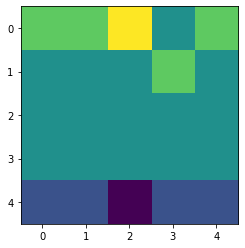

[[[1. 1. 0. 0. 1.]
  [0. 0. 0. 1. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]

 [[0. 0. 1. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [1. 1. 0. 1. 1.]]

 [[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 1. 0. 0.]]

 [[1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1.]]]
False
player 1 plays horse


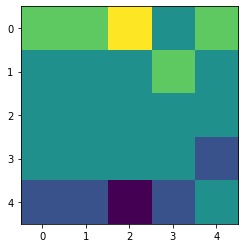

[[[1. 1. 0. 0. 1.]
  [0. 0. 0. 1. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]

 [[0. 0. 1. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 1.]
  [1. 1. 0. 1. 0.]]

 [[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 1. 0. 0.]]

 [[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]]
False
player 0 plays frog


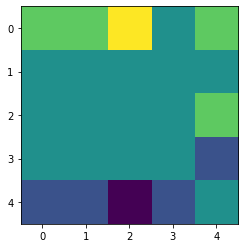

[[[1. 1. 0. 0. 1.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 1.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]

 [[0. 0. 1. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 1.]
  [1. 1. 0. 1. 0.]]

 [[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 1. 0. 0.]]

 [[1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1.]]]
False
player 1 plays boar


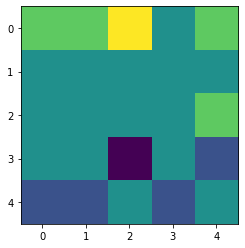

[[[1. 1. 0. 0. 1.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 1.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]

 [[0. 0. 1. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 1.]
  [1. 1. 0. 1. 0.]]

 [[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 1. 0. 0.]
  [0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]]
False
player 0 plays ox


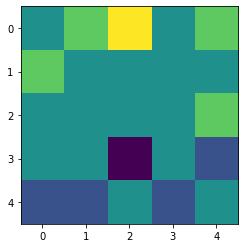

[[[0. 1. 0. 0. 1.]
  [1. 0. 0. 0. 0.]
  [0. 0. 0. 0. 1.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]

 [[0. 0. 1. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 1.]
  [1. 1. 0. 1. 0.]]

 [[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 1. 0. 0.]
  [0. 0. 0. 0. 0.]]

 [[1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1.]]]
False
player 1 plays frog


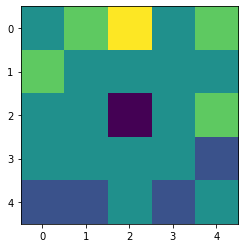

[[[0. 1. 0. 0. 1.]
  [1. 0. 0. 0. 0.]
  [0. 0. 0. 0. 1.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]

 [[0. 0. 1. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 1.]
  [1. 1. 0. 1. 0.]]

 [[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 1. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]]
False
player 0 plays boar


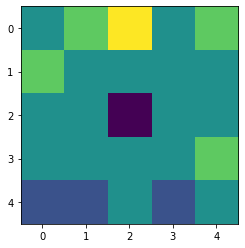

[[[0. 1. 0. 0. 1.]
  [1. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 1.]
  [0. 0. 0. 0. 0.]]

 [[0. 0. 1. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [1. 1. 0. 1. 0.]]

 [[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 1. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]

 [[1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1.]]]
False
player 1 plays ox


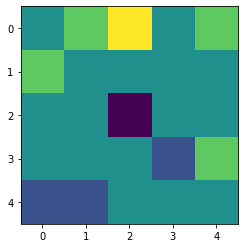

[[[0. 1. 0. 0. 1.]
  [1. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 1.]
  [0. 0. 0. 0. 0.]]

 [[0. 0. 1. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 1. 0.]
  [1. 1. 0. 0. 0.]]

 [[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 1. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]]
False
player 0 plays frog


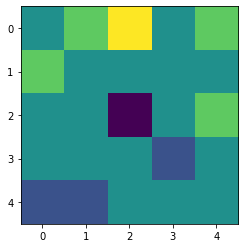

[[[0. 1. 0. 0. 1.]
  [1. 0. 0. 0. 0.]
  [0. 0. 0. 0. 1.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]

 [[0. 0. 1. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 1. 0.]
  [1. 1. 0. 0. 0.]]

 [[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 1. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]

 [[1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1.]]]
False
player 1 plays boar


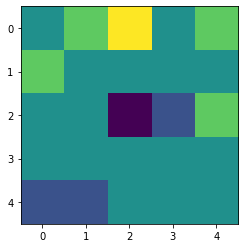

[[[0. 1. 0. 0. 1.]
  [1. 0. 0. 0. 0.]
  [0. 0. 0. 0. 1.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]

 [[0. 0. 1. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 1. 0.]
  [0. 0. 0. 0. 0.]
  [1. 1. 0. 0. 0.]]

 [[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 1. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]]
False
player 0 plays ox


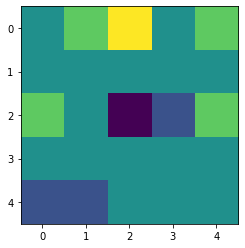

[[[0. 1. 0. 0. 1.]
  [0. 0. 0. 0. 0.]
  [1. 0. 0. 0. 1.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]

 [[0. 0. 1. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 1. 0.]
  [0. 0. 0. 0. 0.]
  [1. 1. 0. 0. 0.]]

 [[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 1. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]

 [[1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1.]]]
False
player 1 plays frog


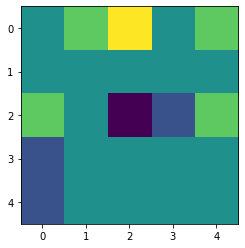

[[[0. 1. 0. 0. 1.]
  [0. 0. 0. 0. 0.]
  [1. 0. 0. 0. 1.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]

 [[0. 0. 1. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 1. 0.]
  [1. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 1. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]]
False
player 0 plays boar


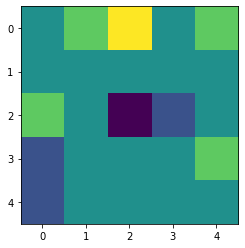

[[[0. 1. 0. 0. 1.]
  [0. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0.]
  [0. 0. 0. 0. 1.]
  [0. 0. 0. 0. 0.]]

 [[0. 0. 1. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 1. 0.]
  [1. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 1. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]

 [[1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1.]]]
False
player 1 plays ox


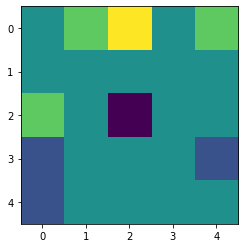

[[[0. 1. 0. 0. 1.]
  [0. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]

 [[0. 0. 1. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [1. 0. 0. 0. 1.]
  [1. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 1. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]]
False
player 0 plays frog


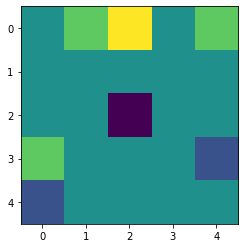

[[[0. 1. 0. 0. 1.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]

 [[0. 0. 1. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 1.]
  [1. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 1. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]

 [[1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1.]]]
False
player 1 plays boar


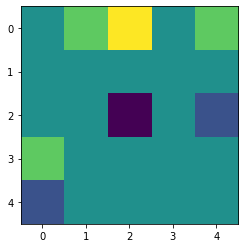

[[[0. 1. 0. 0. 1.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]

 [[0. 0. 1. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 1.]
  [0. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 1. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]]
False
player 0 plays ox


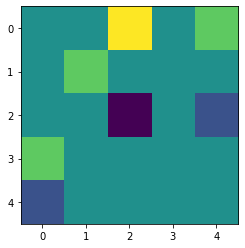

[[[0. 0. 0. 0. 1.]
  [0. 1. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]

 [[0. 0. 1. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 1.]
  [0. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 1. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]

 [[1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1.]]]
False
player 1 plays frog


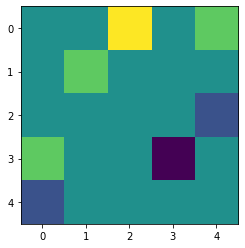

[[[0. 0. 0. 0. 1.]
  [0. 1. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]

 [[0. 0. 1. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 1.]
  [0. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 1. 0.]
  [0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]]
False
player 0 plays horse


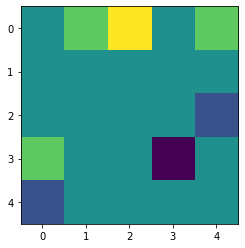

[[[0. 1. 0. 0. 1.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]

 [[0. 0. 1. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 1.]
  [0. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 1. 0.]
  [0. 0. 0. 0. 0.]]

 [[1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1.]]]
False
player 1 plays ox


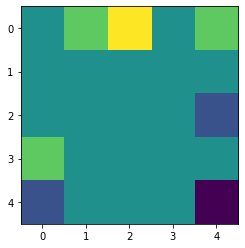

[[[0. 1. 0. 0. 1.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]

 [[0. 0. 1. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 1.]
  [0. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 1.]]

 [[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]]
False


In [15]:
for i in range(20):
    root = root.move(policy)
    plt.imshow(root.board_2D)
    plt.show()
    print(root.is_game_over())